**Problem Statement**
* How do we find anomalies during hardware or hardware/software system validation in order to accelerate bug finding for faster time-to-market?
* Without answering this question, the hardware/system validation teams will not be able to identify anomalies or bugs quickly, and also will not be able to gain quick insights into what types of sequences or patterns cause these anomalies or bugs to occur within the hardware/system.  This will slow down the debugging required to ship the product out the door to the customer, negatively impacting the hardware business.

**Data Source**
* Data source is related to LogBERT-HDFS from Github:

    * https://github.com/HelenGuohx/logbert

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN

In [2]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

**Tokenization and Initial Pre-processing:**

Tokenization and some pre-processing of original logfile, HDFS.log, was done using scripts from the GitHub website below:
https://github.com/HelenGuohx/logbert

These scripts were created by the author of the above website.

After these scripts were run, hdfs_sequence_labels.csv was created, where the tokens are represented as a list of token IDs within the column EventSequence.

In [4]:
data = pd.read_csv('hdfs_sequence_labels.csv')
data.head()

,BlockId,EventSequence,Label
0,blk_-1608999687919862906,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 11, 1,...",normal
1,blk_7503483334202473044,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 8, 10,...",normal
2,blk_-3544583377289625738,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 8, 2, 2, 2, 8, ...",abnormal
3,blk_-9073992586687739851,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal
4,blk_7854771516489510256,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal


**Initial Encoding**

These functions below are used to create new columns based on info in EventSequence to help with the clustering in order to define the normal vs. anomaly classes.

In [5]:
# converts string to list and then computes its length
def ListLen(s):
    s = s[1:-1]  # delete "[" and "]"
    l1 = s.split(', ') # split string into a list
    l1 = [eval(i) for i in l1] # convert each element of list from string to numeric
    return len(l1)

In [6]:
# converts string to list and then computes its sum
def ListSum(s):
    s = s[1:-1]  # delete "[" and "]"
    l1 = s.split(', ') # split string into a list
    l1 = [eval(i) for i in l1] # convert each element of list from string to numeric
    return sum(l1)

In [7]:
# converts string to list and then computes its maximum
def ListMax(s):
    s = s[1:-1]  # delete "[" and "]"
    l1 = s.split(', ') # split string into a list
    l1 = [eval(i) for i in l1] # convert each element of list from string to numeric
    return max(l1)

In [8]:
# converts string to list and then computes its minimum
def ListMin(s):
    s = s[1:-1]  # delete "[" and "]"
    l1 = s.split(', ') # split string into a list
    l1 = [eval(i) for i in l1] # convert each element of list from string to numeric
    return min(l1)

In [9]:
## source: https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/
def most_frequent(s):
    s = s[1:-1]  # delete "[" and "]"
    List = s.split(', ') # split string into a list
    unique, counts = np.unique(List, return_counts=True)
    index = np.argmax(counts)
    #print("unique:")
    #print(unique)
    #print("counts:")
    #print(counts)
    return int(unique[index])

#cnt1 = most_frequent('[1, 2, 2, 34, 2, 34, 7]')
#cnt1

In [10]:
## Encode the EventSequence column into length and sum of lists within it.
data['seq_len'] = data['EventSequence'].apply(ListLen)
data['seq_sum'] = data['EventSequence'].apply(ListSum)
data['seq_max'] = data['EventSequence'].apply(ListMax)
data['seq_min'] = data['EventSequence'].apply(ListMin)
data['seq_freq1'] = data['EventSequence'].apply(most_frequent) # most frequent word/token ID in sequence

data.head()

,BlockId,EventSequence,Label,seq_len,seq_sum,seq_max,seq_min,seq_freq1
0,blk_-1608999687919862906,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 11, 1,...",normal,269,2067,21,1,8
1,blk_7503483334202473044,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 8, 10,...",normal,22,98,10,1,1
2,blk_-3544583377289625738,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 8, 2, 2, 2, 8, ...",abnormal,223,1709,15,1,8
3,blk_-9073992586687739851,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,22,100,10,1,1
4,blk_7854771516489510256,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9


**Class Creation Using Unsupervised Learning**

KMeans clustering, an unsupervised learning algorithm, was applied in order to create the classes of normal and anomaly, since in the real world the dataset to create the models from might not have pre-defined class labels.

In [11]:
## apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(data[['seq_len', 'seq_sum', 'seq_max', 'seq_min', 'seq_freq1']])
data['cluster_labels'] = kmeans.labels_
data.head(10)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,BlockId,EventSequence,Label,seq_len,seq_sum,seq_max,seq_min,seq_freq1,cluster_labels
0,blk_-1608999687919862906,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 11, 1,...",normal,269,2067,21,1,8,4
1,blk_7503483334202473044,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 8, 10,...",normal,22,98,10,1,1,0
2,blk_-3544583377289625738,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 8, 2, 2, 2, 8, ...",abnormal,223,1709,15,1,8,4
3,blk_-9073992586687739851,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,22,100,10,1,1,0
4,blk_7854771516489510256,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9,1
5,blk_1717858812220360316,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9,1
6,blk_-2519617320378473615,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9,1
7,blk_7063315473424667801,"[1, 1, 1, 7, 3, 4, 3, 4, 2, 2, 3, 4, 2, 10, 10...",normal,38,243,10,1,9,1
8,blk_8586544123689943463,"[1, 1, 1, 7, 3, 4, 3, 3, 4, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9,1
9,blk_2765344736980045501,"[1, 1, 7, 1, 3, 4, 3, 4, 2, 3, 4, 2, 2, 10, 10...",normal,38,243,10,1,9,1


In [12]:
data['cluster_labels'].value_counts()

cluster_labels
2    328837
3    107947
0    100122
1     38111
4        44
Name: count, dtype: int64

In [13]:
## Classify cluster labels of 1 and 4 as anomalies, since these are a small minority.
clus = data['cluster_labels'].values
cond1 = (clus == 1)
cond2 = (clus == 4)
data['cluster_cls'] = np.where(cond1 | cond2, 'anomaly', 'normal')
data.head()

,BlockId,EventSequence,Label,seq_len,seq_sum,seq_max,seq_min,seq_freq1,cluster_labels,cluster_cls
0,blk_-1608999687919862906,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 11, 1,...",normal,269,2067,21,1,8,4,anomaly
1,blk_7503483334202473044,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 8, 10,...",normal,22,98,10,1,1,0,normal
2,blk_-3544583377289625738,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 8, 2, 2, 2, 8, ...",abnormal,223,1709,15,1,8,4,anomaly
3,blk_-9073992586687739851,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,22,100,10,1,1,0,normal
4,blk_7854771516489510256,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9,1,anomaly


**Natural Language Processing (NLP) Based Pre-processing and Feature Extraction:**

Lemmatizing was done as part of pre-processing, and vectorization were done to extract the features from the list of token IDs within the EventSequence column.  The code for vectorization is included in the Pipeline commands used during model creation below.

In [14]:
## function for lemmatizing
def lemmatize(text):
    text = text[1:-1]  # delete "[" and "]"
    l1 = text.split(', ') # split string into a list
    #tokens = word_tokenize(text)
    lemma = WordNetLemmatizer()
    lemmatized_words = [lemma.lemmatize(w) for w in l1]
    lemma_str = ' '.join(lemmatized_words)
    
    return lemma_str

In [15]:
lemma_str = lemmatize('[1, 7, 1, 1]')
lemma_str

'1 7 1 1'

In [16]:
df_lemma = data.copy()
df_lemma['PreprocessTokens'] = df_lemma['EventSequence'].apply(lemmatize)
df_lemma.head()

,BlockId,EventSequence,Label,seq_len,seq_sum,seq_max,seq_min,seq_freq1,cluster_labels,cluster_cls,PreprocessTokens
0,blk_-1608999687919862906,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 11, 1,...",normal,269,2067,21,1,8,4,anomaly,1 7 1 1 3 3 4 4 3 4 2 2 2 11 1 12 11 1 21 20 2...
1,blk_7503483334202473044,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 8, 10,...",normal,22,98,10,1,1,0,normal,1 1 7 1 3 4 3 4 3 4 2 2 2 8 10 10 6 6 6 5 5 5
2,blk_-3544583377289625738,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 8, 2, 2, 2, 8, ...",abnormal,223,1709,15,1,8,4,anomaly,1 7 1 1 3 4 3 4 3 4 8 2 2 2 8 8 8 8 8 8 8 8 8 ...
3,blk_-9073992586687739851,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,22,100,10,1,1,0,normal,1 7 1 1 3 4 3 4 3 4 2 2 2 10 10 10 6 6 6 5 5 5
4,blk_7854771516489510256,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9,1,anomaly,1 1 7 1 3 4 3 4 3 4 2 2 2 10 10 10 9 9 9 9 9 9...


In [17]:
X = df_lemma['PreprocessTokens']
y = df_lemma['cluster_cls']

In [18]:
y2 = np.where(y=='normal', 0, 1)

In [19]:
## Split between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.3, random_state=42, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**Classification Models to Predict Normal vs. Anomaly**

Classification models were created to predict if a sequence of token IDs are normal or anomaly.  Here, Decision Tree Classifier and Logistic Regression were used.  Along with the classification algorithm, NLP based vectorization was done to extract features from the list of token IDs.

In [20]:
## Decision Tree
dtree_pipe = Pipeline([\
                       ('cvect', CountVectorizer()),\
                       ('dtree', DecisionTreeClassifier(random_state=42))])
#params1 = {'cvect__max_features': [10, 25, 40, 50], 'cvect__stop_words': ['english', None], \
#          'dtree__max_depth': [1, 3, 5, 7, 9]}
params1 = {'cvect__max_features': [10, 25, 40, 50], 'dtree__max_depth': [1, 3, 5, 7, 9]}
dtree_grid = GridSearchCV(dtree_pipe, param_grid=params1, scoring='recall')
dtree_grid.fit(X_train, y_train)
pred_train = dtree_grid.predict(X_train)
dtree_train_acc = accuracy_score(y_train, pred_train)
pred_test = dtree_grid.predict(X_test)
dtree_test_acc = accuracy_score(y_test, pred_test)
print(f'training accuracy = {dtree_train_acc}')
print(f'test accuracy = {dtree_test_acc}')

## Mean fit time
dtree_mft = np.mean(dtree_grid.cv_results_['mean_fit_time'])
print(f'mean fit time = {dtree_mft}')

## Best parameters
print('best parameters:')
print(dtree_grid.best_params_)

training accuracy = 0.9382772480883982
test accuracy = 0.9378329343434636
mean fit time = 0.5210308790206909
best parameters:
{'cvect__max_features': 40, 'dtree__max_depth': 9}


In [21]:
## Decision Tree precision
dtree_precision = precision_score(y_test, pred_test)
dtree_precision

0.8706365503080082

In [22]:
## Decision Tree recall
dtree_recall = recall_score(y_test, pred_test)
dtree_recall

0.0740805451209924

In [23]:
## Decision Tree: most important features
best_est = dtree_grid.best_estimator_
model = best_est.named_steps['dtree']
importances = model.feature_importances_
print(len(importances))
trans1 = best_est.named_steps['cvect']
features1 = trans1.get_feature_names_out()
print(len(features1))
print(features1)

imp_dict = {'feature': features1, 'importances': importances}
imp_df = pd.DataFrame(imp_dict)
#imp_df['importances'] = imp_df['importances'].apply(abs)
imp_df = imp_df.sort_values(by='importances', ascending=False)
imp_df[:10] # top 10 features based on absolute value of importance

38
38
['10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '21' '22' '23'
 '24' '25' '26' '27' '28' '29' '30' '31' '32' '33' '34' '35' '36' '37'
 '38' '39' '40' '41' '42' '43' '44' '45' '46' '47']


,feature,importances
1,11,0.454425
0,10,0.198897
5,15,0.135913
3,13,0.105538
8,18,0.070886
9,19,0.008253
16,26,0.006295
4,14,0.005029
6,16,0.004660
15,25,0.003655


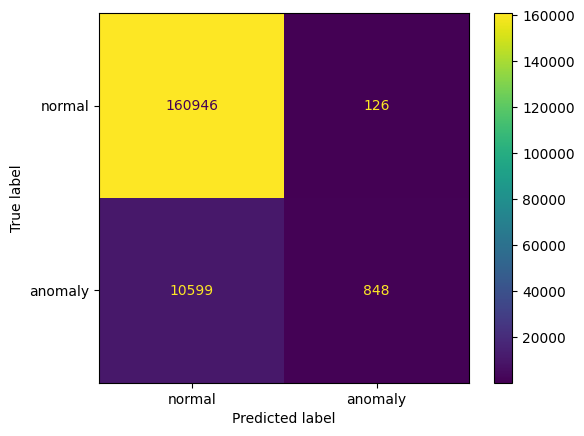

In [24]:
## Decision Tree: confusion matrix
cm = confusion_matrix(y_test, pred_test)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal','anomaly'])
cm_plot.plot()
plt.show()

In [25]:
## Logistic Regression
lgr_pipe = Pipeline([\
                       ('cvect', CountVectorizer()),\
                       ('lgr', LogisticRegression(random_state=42, max_iter=1000))])
params1 = {'cvect__max_features': [10, 25, 40, 50], 'lgr__C': np.logspace(-3,3,10)}
lgr_grid = GridSearchCV(lgr_pipe, param_grid=params1, scoring='recall')
lgr_grid.fit(X_train, y_train)
pred_train = lgr_grid.predict(X_train)
lgr_train_acc = accuracy_score(y_train, pred_train)
pred_test = lgr_grid.predict(X_test)
lgr_test_acc = accuracy_score(y_test, pred_test)
print(f'training accuracy = {lgr_train_acc}')
print(f'test accuracy = {lgr_test_acc}')

## Mean fit time
lgr_mft = np.mean(lgr_grid.cv_results_['mean_fit_time'])
print(f'mean fit time = {lgr_mft}')

## Best parameters
print('best parameters:')
print(lgr_grid.best_params_)

training accuracy = 0.9371345101877568
test accuracy = 0.9368649250227511
mean fit time = 1.1050085365772246
best parameters:
{'cvect__max_features': 40, 'lgr__C': 46.41588833612773}


In [26]:
## Logistic Regression precision
#lgr_precision = precision_score(y_test, pred_test, pos_label='anomaly')
lgr_precision = precision_score(y_test, pred_test)
lgr_precision

0.9809358752166378

In [27]:
## Logistic Regression recall
#lgr_recall = recall_score(y_test, pred_test, pos_label='anomaly')
lgr_recall = recall_score(y_test, pred_test)
lgr_recall

0.049445269502926534

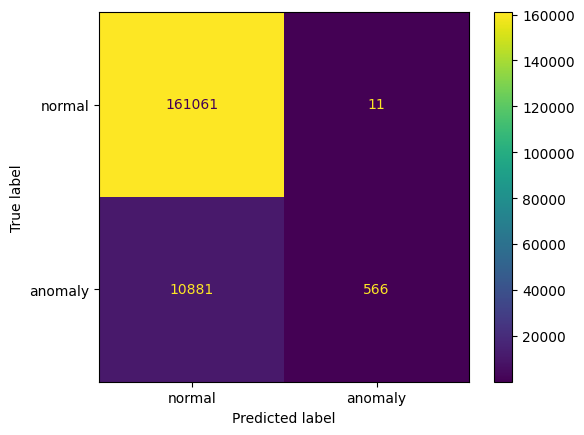

In [28]:
## Logistic Regression Confusion matrix
cm = confusion_matrix(y_test, pred_test)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal','anomaly'])
cm_plot.plot()
plt.show()

In [29]:
y_normal = y_test[y_test==0]
y_anomaly = y_test[y_test==1]
len(y_normal), len(y_anomaly)

(161072, 11447)

In [30]:
## Logistic Regression: find most important features
best_est = lgr_grid.best_estimator_
model = best_est.named_steps['lgr']
coefs = model.coef_[0]
#print(coefs)
#print(len(coefs))
trans1 = best_est.named_steps['cvect']
features1 = trans1.get_feature_names_out()
#print(features1)
#print(len(features1))
coef_dict = {'feature': features1, 'coefs': coefs}
coef_df = pd.DataFrame(coef_dict)
coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by='coefs', ascending=False)
coef_df[:10] # top 10 features based on absolute value of coefficient

,feature,coefs
6,16,8.416458
16,26,4.643492
34,44,3.648225
28,38,3.143089
15,25,3.123675
27,37,3.116206
26,36,2.674151
24,34,2.510086
8,18,2.379913
18,28,2.203549


Text(0, 0.5, 'Absolute value of model coefficient')

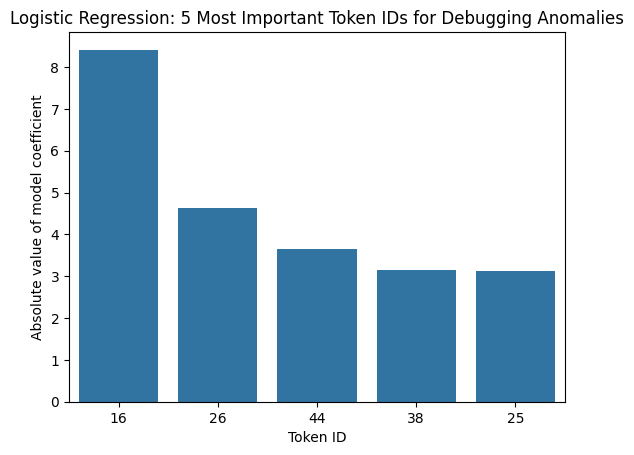

In [31]:
## Logistic Regression: Seaborn plot of top (most important) 5 features for LogisticRegression model
coef_top5 = coef_df[:5]
sns.barplot(data=coef_top5, x='feature', y='coefs')
plt.title('Logistic Regression: 5 Most Important Token IDs for Debugging Anomalies')
plt.xlabel('Token ID')
plt.ylabel('Absolute value of model coefficient')


In [32]:
## Logistic Regression
## Try sweeping the probability thresholds to see if recall can improve
## Probability threshold: probability that sample is normal before it can be classified as normal
predictMatrix = lgr_grid.predict_proba(X_test)
thresh_inds = list(range(1, 10))
prob_thrs1 = [round((0.1*i),1) for i in thresh_inds]
#print(prob_thrs1)
precisions1 = []
recalls1 = []
for prob_thr in prob_thrs1:
    y_pred = np.where(predictMatrix[:, 0] > prob_thr, 0, 1)
    precisions1.append(precision_score(y_test, y_pred))
    recalls1.append(recall_score(y_test, y_pred))
#print(f"precisions1: {precisions1}")
#print(f"recalls1: {recalls1}")

df1_scores = pd.DataFrame({'prob_thresh': prob_thrs1, 'precision': precisions1, 'recall': recalls1})
df1_scores = df1_scores.set_index('prob_thresh')
df1_scores

,precision,recall
prob_thresh,,
0.1,0.956250,0.013366
0.2,0.983051,0.035468
0.3,0.976247,0.035905
0.4,0.982548,0.049183
0.5,0.980936,0.049445
0.6,0.772395,0.073818
0.7,0.470588,0.080370
0.8,0.474518,0.083777
0.9,0.314262,0.098366


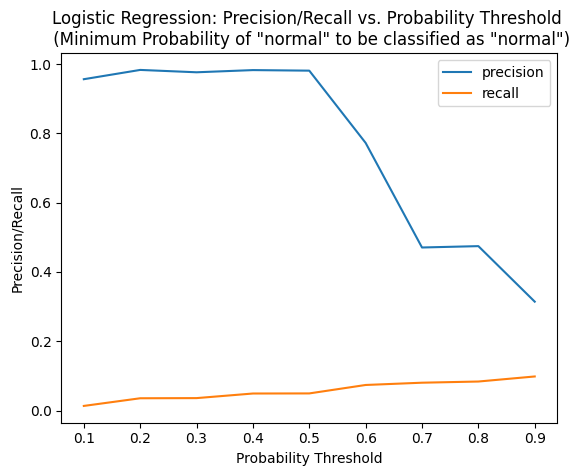

In [33]:
## Logistic Regression
## Plots of precision and recall vs. probability threshold
## Tried the probability threshold range from 0.1 to 0.9, but recall didn't improve much,
## so keeping the default settings.
plt.plot(prob_thrs1, precisions1, label='precision')
plt.plot(prob_thrs1, recalls1, label='recall')
plt.title('Logistic Regression: Precision/Recall vs. Probability Threshold \n (Minimum Probability of "normal" to be classified as "normal")')
plt.xlabel('Probability Threshold')
plt.ylabel('Precision/Recall')
plt.xticks(prob_thrs1)
plt.legend()

In [34]:
## Dataframe summary of LogisticRegression and DecisionTree comparison
cls_summary = pd.DataFrame({'model': ['DecisionTree', 'LogisticRegression'],\
                           'test_accuracy': [round(dtree_test_acc, 2), round(lgr_test_acc, 2)],\
                           'precision': [round(dtree_precision, 2), round(lgr_precision, 2)],\
                           'recall': [round(dtree_recall, 2), round(lgr_recall, 2)],\
                           'mean_fit_time': [round(dtree_mft, 4), round(lgr_mft, 4)]}).set_index('model')
cls_summary

,test_accuracy,precision,recall,mean_fit_time
model,,,,
DecisionTree,0.94,0.87,0.07,0.521
LogisticRegression,0.94,0.98,0.05,1.105


Text(0, 0.5, 'Mean Fit Time')

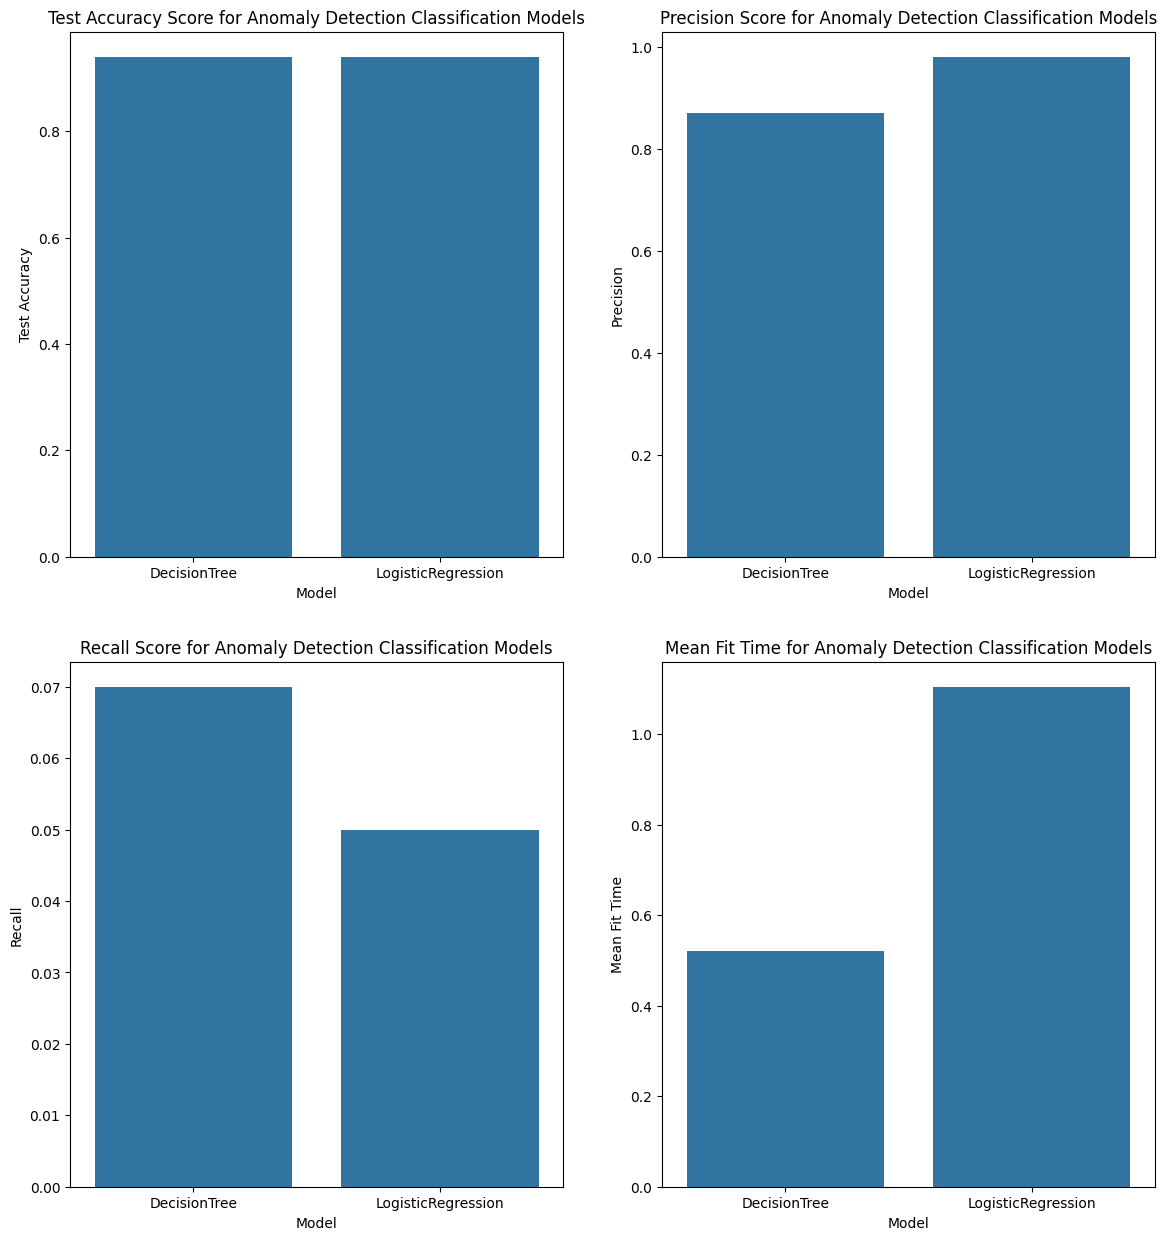

In [40]:
## Plots of Test Accuracy and Precision Score vs. Model Type
fig, ax = plt.subplots(2, 2, figsize = (14, 15))
sns.barplot(data=cls_summary, x=cls_summary.index, y='test_accuracy', ax=ax[0][0])
ax[0][0].set_title('Test Accuracy Score for Anomaly Detection Classification Models')
ax[0][0].set_xlabel('Model')
ax[0][0].set_ylabel('Test Accuracy')
sns.barplot(data=cls_summary, x=cls_summary.index, y='precision', ax=ax[0][1])
ax[0][1].set_title('Precision Score for Anomaly Detection Classification Models')
ax[0][1].set_xlabel('Model')
ax[0][1].set_ylabel('Precision')
sns.barplot(data=cls_summary, x=cls_summary.index, y='recall', ax=ax[1][0])
ax[1][0].set_title('Recall Score for Anomaly Detection Classification Models')
ax[1][0].set_xlabel('Model')
ax[1][0].set_ylabel('Recall')
sns.barplot(data=cls_summary, x=cls_summary.index, y='mean_fit_time', ax=ax[1][1])
ax[1][1].set_title('Mean Fit Time for Anomaly Detection Classification Models')
ax[1][1].set_xlabel('Model')
ax[1][1].set_ylabel('Mean Fit Time')

**Summary and Conclusions**
* Both Decision Tree and Logistic Regression have equal and high test accuracy (94% accuracy).
* For both models, precision is high but recall is low.  This means that false predictions of anomalies is low, but false predictions of normal is high.
* Main advantage of Decision Tree model is the speed, where mean fit time is less.
* Further work needs to be done to find a model which improves the recall score without making the precision score signifantly worse.
* Recommendation would be to use the Logistic Regression model, since this has higher precision score.
* The most importance features to analyze while debugging the anomalies are these token IDs
    * token ID 16
    * token ID 26
    * token ID 44
    * token ID 38
    * token ID 25
* Important for the system validation user to check for the words or tokens corresponding to the above token IDs within the original logfile in order to debug the source of the anomalies or bugs. 